# Lab 6 -  Model comparison

In this excercise we will learn about comparing models using metrics predicting out of sample behavior.

Main idea is to instead of splitting the dataset into two parts (test and training set) to estimate how model would behave in presence of new data.
This is being done by evaluating so called *log likelihood* which is an array of values of logarithm of likelihood for each of datapoints individually.

We will use this informations with two metrics:
- Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model
- PSIS-LOOCV - Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time. 

For this excercise code is provided in form of print-screens. 


In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
F = len("Rafal")
L = len("Guzek")
N = (L + F) * 100

### Exercise 1 - generate data

In [3]:
model_1=CmdStanModel(stan_file='code_1.stan')

data_N = dict(N=N)
sim_1=model_1.sample(data=data_N,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [4]:
model_2=CmdStanModel(stan_file='code_2.stan')

sim_2=model_2.sample(data=data_N,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [5]:
data1_df = sim_1.draws_pd()
data2_df = sim_2.draws_pd()

In [6]:
data1_df.head()

,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,0.0,0.0,0.01,-0.424502,-0.063661,-0.833885,1.551580,-0.362245,0.743487,0.970844,...,-0.419821,0.510223,-0.055905,0.800251,-1.655780,1.039720,1.156010,1.056100,1.048080,-0.668507
1,0.0,0.0,0.01,0.691707,-0.718324,1.510380,-0.515844,-0.759546,0.823583,-1.203840,...,-0.151676,-0.139082,0.581032,-0.161371,-0.744724,-0.440833,0.770468,-0.245155,-0.692138,0.457749
2,0.0,0.0,0.01,0.454723,0.553359,-0.858150,0.623616,0.170166,-0.984149,-0.441384,...,-1.227770,4.536370,0.846926,-0.978754,-0.689286,1.996560,-0.463004,1.485180,1.273640,1.266120
3,0.0,0.0,0.01,-0.419475,-1.141710,0.318598,-0.025358,0.357122,-0.721668,0.014098,...,-0.544827,-0.023012,-0.384155,-0.073107,1.208040,1.561990,0.206984,-1.412740,-0.303845,-0.111587
4,0.0,0.0,0.01,-1.087330,-0.518329,-0.659032,2.376360,-0.239320,0.112092,-0.412680,...,0.876384,0.827360,-0.654178,-1.051340,0.073445,2.634920,0.305851,-0.159827,0.017941,-0.666121


In [7]:
data2_df.head()

,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,0.0,0.0,2.708170,0.777181,-1.272270,0.127591,-1.389420,0.246162,1.198730,2.265330,...,2.434840,-1.690430,-1.11724,1.018020,-3.209390,0.647371,-1.979340,-0.181075,-3.39436,-0.348991
1,0.0,0.0,1.719960,-1.233320,-2.029110,-0.255109,-0.254564,-0.802033,-1.179080,0.642103,...,0.281867,-0.194551,-0.04624,0.257383,0.052754,1.265270,1.353620,-1.023080,1.81499,0.723555
2,0.0,0.0,-0.178648,-1.562320,0.018253,1.255490,-1.255040,1.439220,1.067550,2.428280,...,0.553336,4.579340,2.01411,2.175650,0.476137,-1.573090,1.990880,4.495600,-4.44428,-1.622950
3,0.0,0.0,0.452558,1.807660,-0.188759,-0.604655,-1.631600,0.876941,0.609006,-0.685728,...,-0.266918,1.815600,4.78667,3.541330,0.954445,7.538290,2.084000,0.801006,-3.43066,2.458280
4,0.0,0.0,-1.007140,-0.545801,-0.663748,-1.084900,-1.741290,-0.621120,-2.058940,0.671296,...,0.494235,0.732109,-1.87848,0.970899,-4.988100,-4.434610,0.059459,-3.672500,3.42084,-0.928078


### Exercise 2 - compare normal and student models

In [8]:
y_data1 = data1_df.loc[:, 'y[1]':f'y[{N}]']
y_data1.head()

,y[1],y[2],y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,-0.424502,-0.063661,-0.833885,1.551580,-0.362245,0.743487,0.970844,0.555378,0.598941,1.399070,...,-0.419821,0.510223,-0.055905,0.800251,-1.655780,1.039720,1.156010,1.056100,1.048080,-0.668507
1,0.691707,-0.718324,1.510380,-0.515844,-0.759546,0.823583,-1.203840,0.280014,-0.668970,1.579490,...,-0.151676,-0.139082,0.581032,-0.161371,-0.744724,-0.440833,0.770468,-0.245155,-0.692138,0.457749
2,0.454723,0.553359,-0.858150,0.623616,0.170166,-0.984149,-0.441384,-1.450820,0.307736,1.808740,...,-1.227770,4.536370,0.846926,-0.978754,-0.689286,1.996560,-0.463004,1.485180,1.273640,1.266120
3,-0.419475,-1.141710,0.318598,-0.025358,0.357122,-0.721668,0.014098,0.605672,-1.860580,0.943592,...,-0.544827,-0.023012,-0.384155,-0.073107,1.208040,1.561990,0.206984,-1.412740,-0.303845,-0.111587
4,-1.087330,-0.518329,-0.659032,2.376360,-0.239320,0.112092,-0.412680,-1.029170,1.563720,0.333931,...,0.876384,0.827360,-0.654178,-1.051340,0.073445,2.634920,0.305851,-0.159827,0.017941,-0.666121


In [9]:
y_data1_np = y_data1.values[0, :]
data1_fit = dict(N=N, y=y_data1_np)

In [10]:
model_3=CmdStanModel(stan_file='code_3.stan')

sim_3_fit1=model_3.sample(data=data1_fit,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [11]:
model_4=CmdStanModel(stan_file='code_4.stan')

sim_4_fit1=model_4.sample(data=data1_fit,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)





chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [12]:
sim_3_fit1_df = sim_3_fit1.draws_pd()
sim_4_fit1_df = sim_4_fit1.draws_pd()

In [13]:
sim_3_fit1_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1798.25,0.990257,0.770827,2.0,3.0,0.0,1799.22,1.46568,0.058701,-1.35560,...,-0.544100,-1.043440,0.522979,-0.574911,0.972840,-0.073779,1.22572,-0.584332,-1.199990,1.553420
1,-1798.33,0.984009,0.770827,3.0,7.0,0.0,1798.68,1.49253,0.073942,-1.37518,...,-0.038372,-0.010576,-1.319480,-1.965120,-1.049040,-1.411330,-3.07895,1.146830,3.304600,0.676324
2,-1798.40,0.990283,0.770827,3.0,7.0,0.0,1798.93,1.43002,0.089837,-1.34131,...,0.836992,-0.599305,-2.425250,0.790164,2.924610,2.475240,2.77630,-0.607805,-1.989640,0.811731
3,-1800.07,0.858500,0.770827,2.0,7.0,0.0,1800.77,1.41701,0.172495,-1.35624,...,-1.852560,-0.013216,-0.019763,0.797708,0.900528,-0.213723,-1.93547,0.346935,0.496456,2.794080
4,-1799.18,0.975933,0.770827,2.0,3.0,0.0,1801.11,1.47508,0.180122,-1.39165,...,-2.562720,0.044293,-2.430790,1.418290,-0.848196,1.660680,-2.66769,-3.410690,0.500766,-0.312754


In [14]:
sim_4_fit1_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[991],y_hat[992],y_hat[993],y_hat[994],y_hat[995],y_hat[996],y_hat[997],y_hat[998],y_hat[999],y_hat[1000]
0,-1480.46,0.941503,0.604221,2.0,7.0,0.0,1482.43,0.826324,0.022313,3.94314,...,0.893822,-0.402850,0.952488,-0.418644,0.444629,1.112830,-1.364650,0.988745,0.732745,-0.270454
1,-1481.45,0.840891,0.604221,3.0,7.0,0.0,1482.23,0.801454,0.042741,4.48396,...,0.705129,0.227963,-0.046660,-1.722080,-1.022640,0.859354,3.414280,-0.322643,0.751054,1.774210
2,-1481.72,0.980309,0.604221,2.0,3.0,0.0,1482.05,0.847333,0.041165,3.80827,...,1.871900,-1.537190,0.923154,-0.925310,0.451864,0.336611,-0.447675,0.118706,-1.911410,0.062619
3,-1480.79,0.932620,0.604221,3.0,7.0,0.0,1482.74,0.816642,-0.002646,4.35410,...,0.410984,-0.077361,0.254482,2.009350,-0.583305,-1.834020,-0.210459,1.384500,1.716250,-0.757751
4,-1480.84,0.998087,0.604221,2.0,3.0,0.0,1481.21,0.837047,-0.010435,4.27772,...,-0.486360,-0.113052,-1.192770,0.414464,0.561073,0.576224,-0.290485,-3.355320,1.722830,-0.711896


#### Model comparison

In [15]:
print("----------- loo -----------")
print(az.loo(sim_3_fit1))
print("----------- waic -----------")
print(az.waic(sim_3_fit1))

----------- loo -----------


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 1000 log-likelihood matrix

         Estimate       SE
elpd_loo -1815.62   129.68
p_loo       31.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      997   99.7%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    0.2%
   (1, Inf)   (very bad)    1    0.1%

----------- waic -----------
Computed from 4000 by 1000 log-likelihood matrix

          Estimate       SE
elpd_waic -1816.64   130.22
p_waic       32.57        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [16]:
print("----------- loo -----------")
print(az.loo(sim_4_fit1))
print("----------- waic -----------")
print(az.waic(sim_4_fit1))


----------- loo -----------
Computed from 4000 by 1000 log-likelihood matrix

         Estimate       SE
elpd_loo -1481.35    34.90
p_loo        4.62        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

----------- waic -----------
Computed from 4000 by 1000 log-likelihood matrix

          Estimate       SE
elpd_waic -1481.33    34.90
p_waic        4.60        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [17]:
InferenceData3_fit1 = az.from_cmdstanpy(posterior=sim_3_fit1)
InferenceData4_fit1 = az.from_cmdstanpy(posterior=sim_4_fit1)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


               rank          loo      p_loo       d_loo        weight  \
student model     0 -1481.348903   4.619085    0.000000  1.000000e+00   
normal model      1 -1815.617002  31.545393  334.268099  6.970708e-10   

                       se         dse  warning loo_scale  
student model   34.903089    0.000000    False       log  
normal model   129.679342  105.752283     True       log  


Text(0.5, 1.0, 'Loo for code_1')

<Figure size 432x288 with 0 Axes>

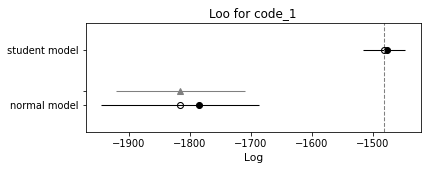

In [18]:
compare_model_3_4_fit1=az.compare({"normal model":InferenceData3_fit1,"student model":InferenceData4_fit1}, ic='loo')
print(compare_model_3_4_fit1)

plt.figure()
az.plot_compare(compare_model_3_4_fit1)
plt.title("Loo for code_1")

               rank         waic     p_waic      d_waic        weight  \
student model     0 -1481.332718   4.602900    0.000000  1.000000e+00   
normal model      1 -1816.643956  32.572347  335.311238  2.890488e-11   

                       se        dse  warning waic_scale  
student model   34.897756    0.00000     True        log  
normal model   130.224291  106.31446     True        log  


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Text(0.5, 1.0, 'Waic for code_1')

<Figure size 432x288 with 0 Axes>

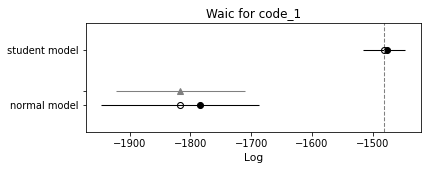

In [19]:
compare_model_3_4_fit1=az.compare({"normal model":InferenceData3_fit1,"student model":InferenceData4_fit1}, ic='waic')
print(compare_model_3_4_fit1)

plt.figure()
az.plot_compare(compare_model_3_4_fit1)
plt.title("Waic for code_1")

### Exercise 3 - compare models with different number of predictors

In [20]:
data2_df.head()

,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999],y[1000]
0,0.0,0.0,2.708170,0.777181,-1.272270,0.127591,-1.389420,0.246162,1.198730,2.265330,...,2.434840,-1.690430,-1.11724,1.018020,-3.209390,0.647371,-1.979340,-0.181075,-3.39436,-0.348991
1,0.0,0.0,1.719960,-1.233320,-2.029110,-0.255109,-0.254564,-0.802033,-1.179080,0.642103,...,0.281867,-0.194551,-0.04624,0.257383,0.052754,1.265270,1.353620,-1.023080,1.81499,0.723555
2,0.0,0.0,-0.178648,-1.562320,0.018253,1.255490,-1.255040,1.439220,1.067550,2.428280,...,0.553336,4.579340,2.01411,2.175650,0.476137,-1.573090,1.990880,4.495600,-4.44428,-1.622950
3,0.0,0.0,0.452558,1.807660,-0.188759,-0.604655,-1.631600,0.876941,0.609006,-0.685728,...,-0.266918,1.815600,4.78667,3.541330,0.954445,7.538290,2.084000,0.801006,-3.43066,2.458280
4,0.0,0.0,-1.007140,-0.545801,-0.663748,-1.084900,-1.741290,-0.621120,-2.058940,0.671296,...,0.494235,0.732109,-1.87848,0.970899,-4.988100,-4.434610,0.059459,-3.672500,3.42084,-0.928078


In [21]:
model_5=CmdStanModel(stan_file='code_5.stan')
num_of_preds = [1, 2, 3]
pred_code5 = []

for num_of_pred in num_of_preds:
    y_data2 = data2_df.loc[:, 'y[1]':f'y[{N}]'].values[0, :]
    X_data2 = data2_df.loc[:, 'X[1,1]':f'X[{N},{num_of_pred}]'].values[0, :].reshape((N, num_of_pred))
    data2_fit2 = dict(N=N, K=num_of_pred, y=y_data2, X=X_data2)

    pred=model_5.sample(data=data2_fit2,
                        seed=29042020)
    pred_code5.append(pred)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [22]:
models_to_compare = {f"Predictors = {num_of_pred}" : az.from_cmdstanpy(posterior=pred_code5[i]) for i, num_of_pred in enumerate(num_of_preds)}

                rank          loo     p_loo       d_loo        weight  \
Predictors = 1     0 -1817.413522  2.087206    0.000000  1.000000e+00   
Predictors = 2     1 -2351.862350  2.908067  534.448828  2.968657e-15   
Predictors = 3     2 -2352.660514  3.841749  535.246992  0.000000e+00   

                       se        dse  warning loo_scale  
Predictors = 1  22.740188   0.000000    False       log  
Predictors = 2  21.888502  25.516854    False       log  
Predictors = 3  21.850000  25.498191    False       log  


Text(0.5, 1.0, 'Loo for code_5')

<Figure size 432x288 with 0 Axes>

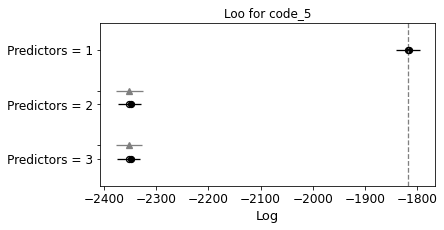

In [23]:
compare_model_5_fit2=az.compare(models_to_compare, ic='loo')
print(compare_model_5_fit2)

plt.figure()
az.plot_compare(compare_model_5_fit2)
plt.title("Loo for code_5")

                rank         waic    p_waic      d_waic        weight  \
Predictors = 1     0 -1817.413533  2.087217    0.000000  1.000000e+00   
Predictors = 2     1 -2351.862401  2.908118  534.448868  0.000000e+00   
Predictors = 3     2 -2352.660331  3.841566  535.246798  1.998401e-15   

                       se        dse  warning waic_scale  
Predictors = 1  22.740193   0.000000    False        log  
Predictors = 2  21.888523  25.516864    False        log  
Predictors = 3  21.849990  25.498183    False        log  


Text(0.5, 1.0, 'Waic for code_5')

<Figure size 432x288 with 0 Axes>

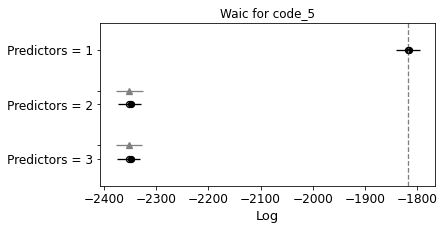

In [24]:
compare_model_5_fit2=az.compare(models_to_compare, ic='waic')
print(compare_model_5_fit2)

plt.figure()
az.plot_compare(compare_model_5_fit2)
plt.title("Waic for code_5")